In [4]:
"""
``autoreload`` is an IPython extension that reloads modules
automatically before executing the line of code typed.
"""

%load_ext autoreload
%autoreload 2

# Timeseries forecasting with ARIMA model

---

## Loading modules and reading the data

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels as sm
import sklearn as sl

from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings('ignore')

In [6]:
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Statsmodels version: {sm.__version__}")
print(f"Scikit-Learn version: {sl.__version__}")


Pandas version: 2.0.3
Numpy version: 1.24.3
Statsmodels version: 0.14.1
Scikit-Learn version: 1.3.0


In [7]:
RAW_DATA_PATH = Path('__file__').absolute().parents[1] / 'data' / '01_raw'
PROCESSED_DATA_PATH = Path('__file__').absolute().parents[1] / 'data' / '02_processed'

In [8]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = [15, 8]

In [9]:
sns.set_style('whitegrid')

In [10]:
def read_and_format_csv(subfolder_path: Path, raw_path: bool = True) -> pd.DataFrame:
    if raw_path:
        path = str(RAW_DATA_PATH / subfolder_path)
        df = pd.read_csv(path)
    else:
        path = str(PROCESSED_DATA_PATH / subfolder_path)
        df = pd.read_csv(path)
        
    
    df = df.astype({col: 'float32' for col in ['Open', 'High', 'Low', 'Close', 'Adj Close',]})
    df['stock_name'] = df['stock_name'].astype('str')
    df['Volume'] = df['Volume'].astype('int32')

    df['Date'] = pd.to_datetime(df['Date'], format='ISO8601', utc='True')
    df['Date'] = pd.to_datetime(df['Date'].dt.date)
    return df

In [11]:
df = read_and_format_csv(subfolder_path='Information_Technology/AAPL.csv', raw_path=True)

In [12]:
df.sort_values(by='Date', inplace=True)
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL
2,1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000,AAPL
3,1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600,AAPL
4,1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600,AAPL


In [13]:
df.shape

(11074, 8)

In [14]:
df.dtypes

Date          datetime64[ns]
Adj Close            float32
Close                float32
High                 float32
Low                  float32
Open                 float32
Volume                 int32
stock_name            object
dtype: object

#### Notes about the dataset

<ul>
    <li>Daily resolution Apple stock Dataset</li>
    <li>The currency used is American dollar</li>
</ul>

## Focusing on Daily resolution and returns

---

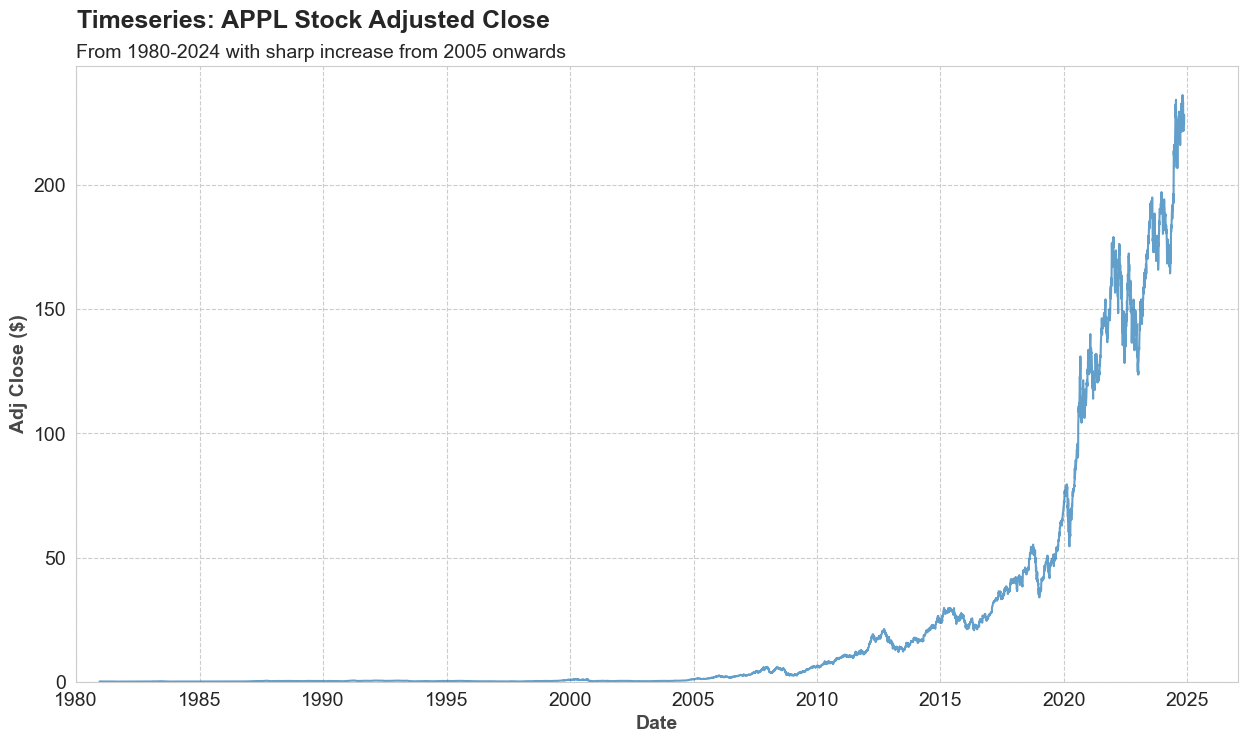

In [15]:
f, ax = plt.subplots(nrows=1, ncols=1,)

sns.lineplot(data=df, x='Date', y='Adj Close', markers='o', alpha=0.7)

ax.set_xlabel('Date', fontsize=14, alpha=0.85, fontweight='bold')
ax.set_ylabel('Adj Close ($)', fontsize=14, alpha=0.85, fontweight='bold')

dx, dy = 0.2835, 0.95
f.suptitle(t='Timeseries: APPL Stock Adjusted Close', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='From 1980-2024 with sharp increase from 2005 onwards', fontsize=14, loc='left')

ax.set_xlim(df['Date'].min() + timedelta(days=-350))
ax.set_ylim(0)
ax.grid(linestyle='--',)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

f.savefig('../outputs/figures/Timeseries_APPL.png', dpi=300)


We can see from this Timeseries that it has Trends but No clearn evidence of seasonality and is definitely not stationary so we need to transform it, I believe I should use first difference or normalised difference (pct change)

In [16]:
df['Returns'] = df['Adj Close'].pct_change()
df['first_diff'] = df['Adj Close'].diff()
df['cumilative_returns'] = (1 + df['Returns']).cumprod() - 1
df['20_day_sma'] = df['Adj Close'].rolling(window=20).mean()
df['50_day_sma'] = df['Adj Close'].rolling(window=50).mean()

df.head(2)

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff,cumilative_returns,20_day_sma,50_day_sma
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL,NaN,NaN,NaN,NaN,NaN
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL,-0.052171,-0.005156,-0.052171,NaN,NaN


In [17]:
df = df.loc[df['Date'].dt.year > pd.Timestamp('1980').year].reset_index(drop=True)
df.head(2)

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff,cumilative_returns,20_day_sma,50_day_sma
0,1981-01-02,0.118602,0.154018,0.155134,0.154018,0.154018,21660800,AAPL,0.010989,0.001289,0.200004,NaN,NaN
1,1981-01-05,0.116024,0.150670,0.151228,0.150670,0.151228,35728000,AAPL,-0.021738,-0.002578,0.173918,NaN,NaN


In [18]:
stats_df = df.iloc[:, 1:].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).applymap(lambda x: f"{x:0.3f}")
stats_df

,Adj Close,Close,High,Low,Open,Volume,Returns,first_diff,cumilative_returns,20_day_sma,50_day_sma
count,11061.000,11061.000,11061.000,11061.000,11061.000,11061.000,11061.000,11061.000,11061.000,11055.000,11025.000
mean,22.894,23.733,23.970,23.473,23.716,302510807.607,0.001,0.021,230.636,22.712,22.462
std,48.390,48.865,49.338,48.341,48.823,321588688.551,0.028,0.916,489.602,48.009,47.419
min,0.038,0.049,0.050,0.049,0.050,-2108338096.000,-0.519,-10.566,-0.617,0.043,0.045
10%,0.104,0.134,0.137,0.133,0.135,68356600.000,-0.028,-0.177,0.052,0.105,0.102
25%,0.244,0.301,0.306,0.292,0.300,111065200.000,-0.013,-0.009,1.465,0.245,0.251
50%,0.442,0.540,0.549,0.531,0.540,203044800.000,0.000,0.000,3.477,0.440,0.438
75%,17.913,21.000,21.236,20.821,21.079,393355200.000,0.014,0.014,180.243,17.644,17.605
90%,87.712,90.015,91.250,88.255,90.020,701153600.000,0.031,0.262,886.458,83.152,77.991
99%,197.055,198.020,198.888,195.934,197.152,1504469680.000,0.078,3.431,1992.773,193.151,189.546


Minimum volume is negative, this is potentially an error we have to explore

#### Exploring negative volume values

In [19]:
df.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'stock_name', 'Returns', 'first_diff', 'cumilative_returns',
       '20_day_sma', '50_day_sma'],
      dtype='object')

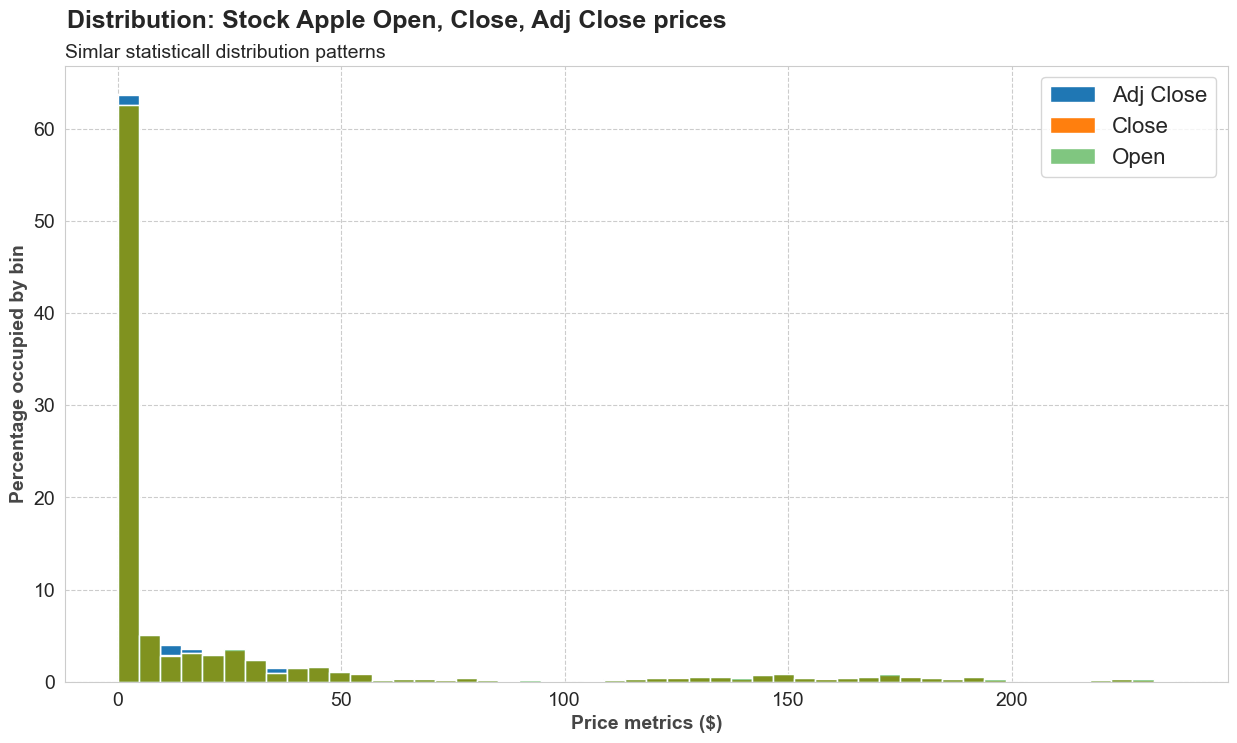

In [20]:
f, ax = plt.subplots()
sns.histplot(df['Adj Close'], bins=50, stat='percent', ax=ax, label='Adj Close', alpha=1)
sns.histplot(df['Close'], bins=50, stat='percent', ax=ax, label='Close', alpha=1)
sns.histplot(df['Open'], bins=50, stat='percent', ax=ax, label='Open', alpha=0.6)

ax.set_xlabel('Price metrics ($)', fontsize=14, alpha=0.85, fontweight='bold')
ax.set_ylabel('Percentage occupied by bin', fontsize=14, alpha=0.85, fontweight='bold')

dx, dy = 0.346, 0.95
f.suptitle(t='Distribution: Stock Apple Open, Close, Adj Close prices', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Simlar statisticall distribution patterns', fontsize=14, loc='left')

ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=16)

ax.grid(linestyle='--',)
plt.show()
f.savefig('../outputs/figures/distribution_open_close_adj_close.png', dpi=300)

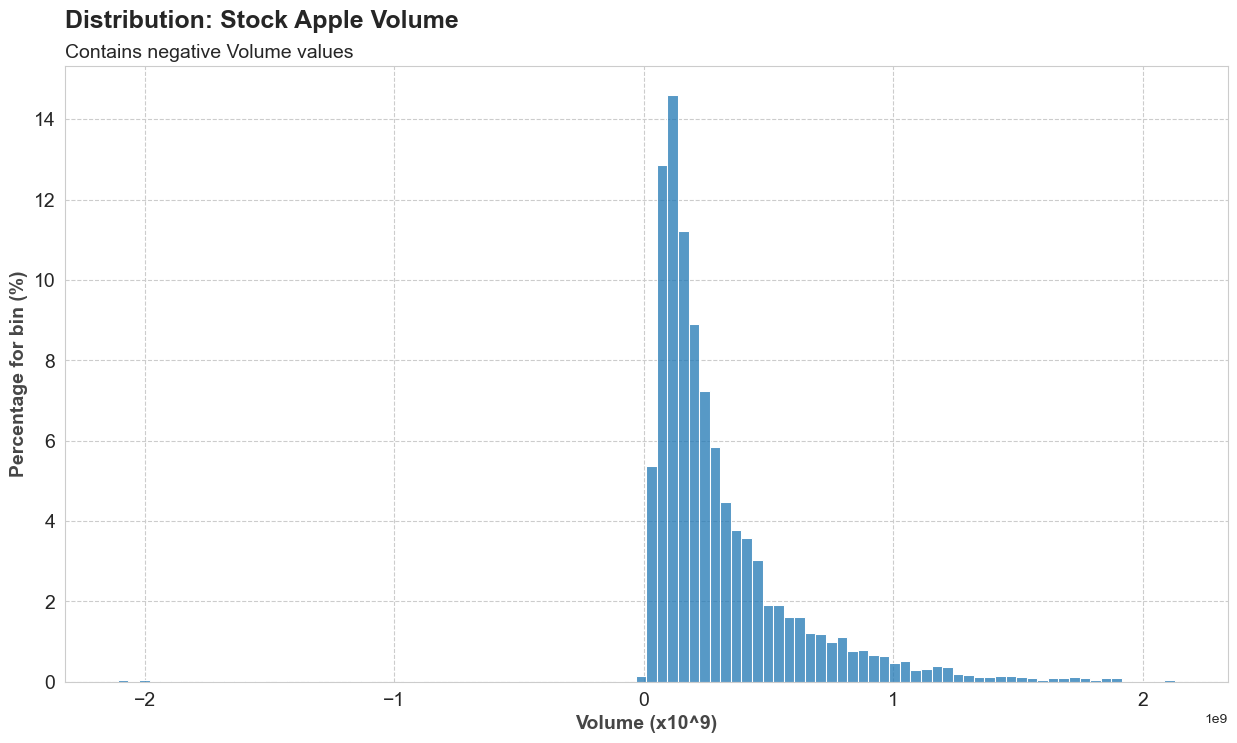

In [21]:
f, ax = plt.subplots()
sns.histplot(df['Volume'], bins=100, stat='percent', ax=ax)

ax.set_xlabel('Volume (x10^9)', fontsize=14, alpha=0.85, fontweight='bold')
ax.set_ylabel('Percentage for bin (%)', fontsize=14, alpha=0.85, fontweight='bold')

dx, dy = 0.256, 0.95
f.suptitle(t='Distribution: Stock Apple Volume', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Contains negative Volume values', fontsize=14, loc='left')
ax.tick_params(axis='both', which='major', labelsize=14)

ax.grid(linestyle='--',)
plt.show()
f.savefig('../outputs/figures/volume_neagtive_values.png', dpi=300)

In [22]:
df[df['Volume'] < 0].head()

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff,cumilative_returns,20_day_sma,50_day_sma
690,1983-09-23,0.083365,0.108259,0.111607,0.099330,0.111607,-1462621696,AAPL,-0.253844,-0.028361,-0.156520,0.111576,0.119143
4196,1997-08-06,0.198177,0.234933,0.247768,0.223214,0.225446,-104487296,AAPL,0.332281,0.049427,1.005139,0.129921,0.121971
4197,1997-08-07,0.219831,0.260603,0.263951,0.253348,0.256696,-539528896,AAPL,0.109265,0.021654,1.224231,0.135923,0.123807
4433,1998-07-16,0.282437,0.334821,0.340402,0.319196,0.338170,-1733616896,AAPL,0.088927,0.023065,1.857675,0.228727,0.219529
4496,1998-10-14,0.281496,0.333705,0.368862,0.328683,0.354911,-2014949696,AAPL,-0.035485,-0.010356,1.848151,0.273353,0.281694


I have validated the values in the Adjusted Close columns with negative volumes with true values online and can confirm the values are correct.

#### Exploring Null values and Duplicates

In [23]:
df.isna().sum()

Date                   0
Adj Close              0
Close                  0
High                   0
Low                    0
Open                   0
Volume                 0
stock_name             0
Returns                0
first_diff             0
cumilative_returns     0
20_day_sma             6
50_day_sma            36
dtype: int64

In [24]:
df.dropna(inplace=True)

In [25]:
df.duplicated().sum()

0

In [26]:
df.reset_index(inplace=True, drop=True)

#### Extra Cleaning

I could've done additional outlier detection where i remove values 1.5 times the interquatile range but I decided to keep the values as they are. This is because stocks are very volatile and these abnormal returns and price values can happen due to economic events. <br>

Additionally as a safety measure I have compared my timeseries to other sources of truth on the internet and can safely say it looks the same.

---

### Checking the stationarity of Returns and first difference and log transforms columns

----

returns and first difference are is the percentage change and first difference of the Adj Close columns

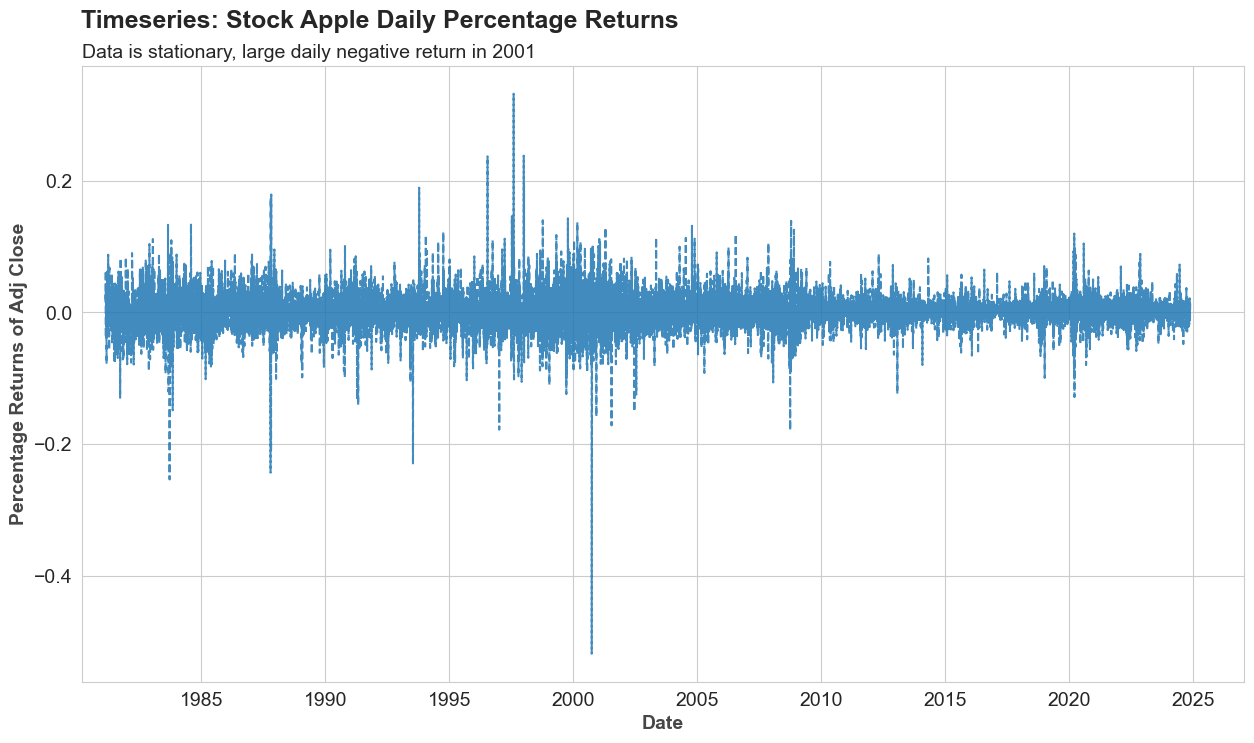

In [27]:
f, ax = plt.subplots()
sns.lineplot(data=df, x='Date', y='Returns', linestyle='--', markers='o', ax=ax, alpha=0.85)


ax.set_xlabel('Date', fontsize=14, alpha=0.85, fontweight='bold')
ax.set_ylabel('Percentage Returns of Adj Close', fontsize=14, alpha=0.85, fontweight='bold')

dx, dy = 0.3235, 0.95
f.suptitle(t='Timeseries: Stock Apple Daily Percentage Returns', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Data is stationary, large daily negative return in 2001', fontsize=14, loc='left')

ax.set_xlim(df['Date'].min() + timedelta(days=-350))
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
f.savefig('../outputs/figures/Timeseries_daily_returns.png', dpi=300)

Timeseries of returns looks stationary maybe left side has more variance than right

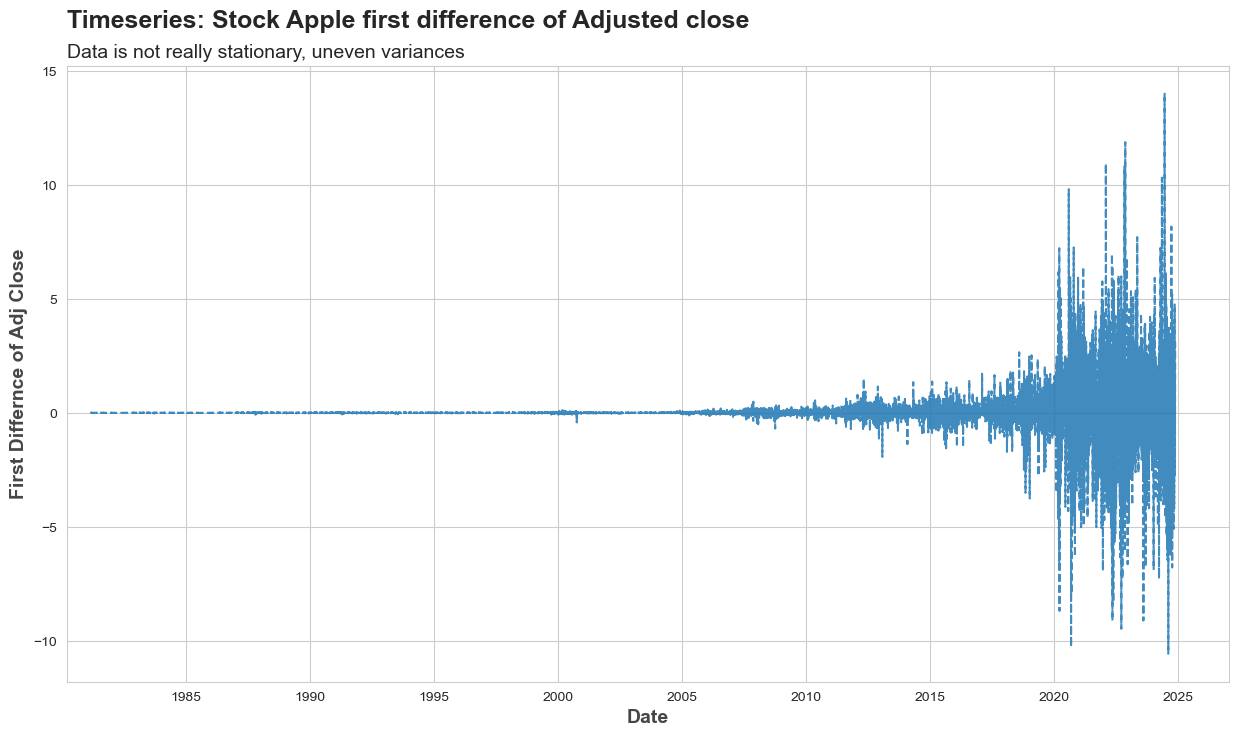

In [28]:
f, ax = plt.subplots()
sns.lineplot(data=df, x='Date', y='first_diff', linestyle='--', markers='o', alpha=0.85)


ax.set_xlabel('Date', fontsize=14, alpha=0.85, fontweight='bold')
ax.set_ylabel('First Differnce of Adj Close', fontsize=14, alpha=0.85, fontweight='bold')

dx, dy = 0.3525, 0.95
f.suptitle(t='Timeseries: Stock Apple first difference of Adjusted close', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Data is not really stationary, uneven variances', fontsize=14, loc='left')

ax.set_xlim(df['Date'].min() + timedelta(days=-350))
plt.show()

The First difference of the adjusted close is not suitable for the ARIMA model as the data has a higher variance after 2020 than before 2020, even if we take 2nd 3rd or nth difference the data is not stationary

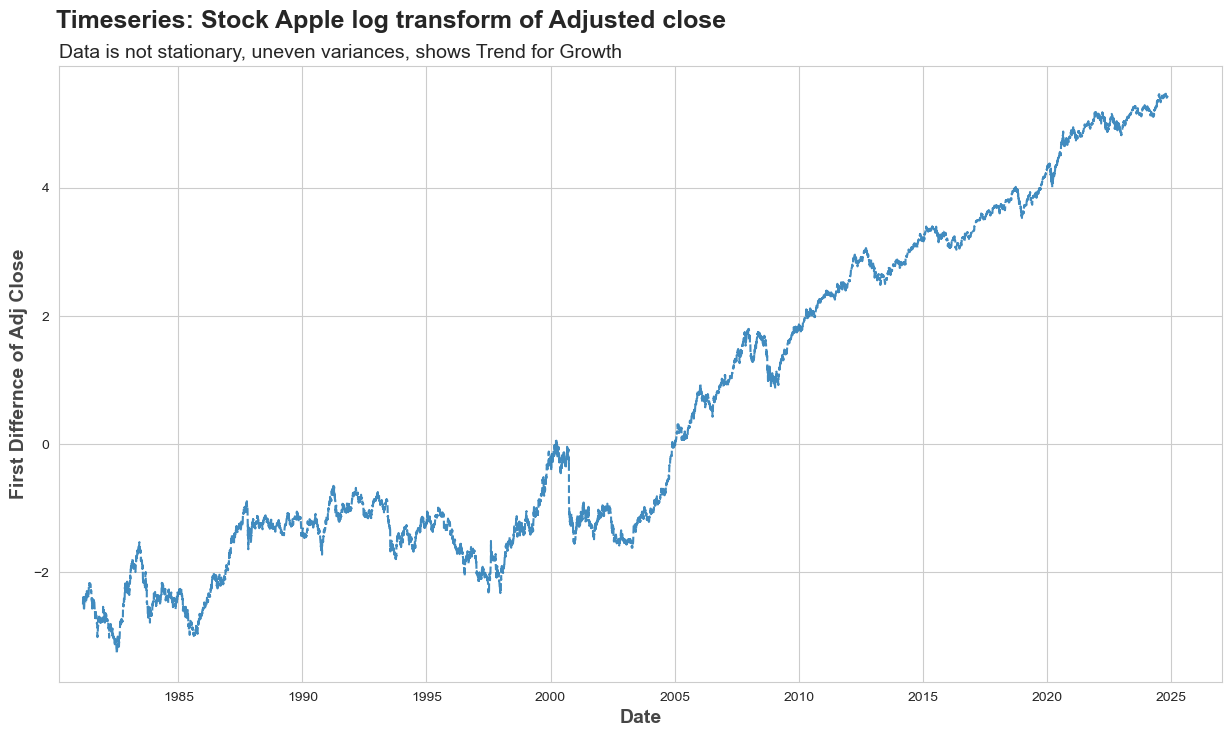

In [29]:
f, ax = plt.subplots()
sns.lineplot(x=df['Date'], y=np.log(df['Adj Close']), linestyle='--', markers='o', alpha=0.85)


ax.set_xlabel('Date', fontsize=14, alpha=0.85, fontweight='bold')
ax.set_ylabel('First Differnce of Adj Close', fontsize=14, alpha=0.85, fontweight='bold')

dx, dy = 0.346, 0.95
f.suptitle(t='Timeseries: Stock Apple log transform of Adjusted close', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Data is not stationary, uneven variances, shows Trend for Growth', fontsize=14, loc='left')

ax.set_xlim(df['Date'].min() + timedelta(days=-350))
plt.show()

---

### Further Analysis of Stock data

---

<font size=5 color=orange>Q </font>-- What does the spread of daily, monthly, annual resolution returns look like?

In [30]:
def calculate_period_returns(df: pd.DataFrame) -> dict:
    df['Date'] = pd.to_datetime(df['Date'])
    
    periods = {
        'daily': df.groupby(df['Date'].dt.date)['Adj Close'],
        'weekly': df.groupby(pd.Grouper(key='Date', freq='W'))['Adj Close'],
        'monthly': df.groupby(pd.Grouper(key='Date', freq='M'))['Adj Close'],
        'quarterly': df.groupby(pd.Grouper(key='Date', freq='Q'))['Adj Close'],
        'yearly': df.groupby(pd.Grouper(key='Date', freq='Y'))['Adj Close']
    }
    
    returns_dict = {}
    for period_name, grouped in periods.items():
        period_changes = grouped.agg(['first', 'last']).dropna()
        returns = (period_changes['last'] - period_changes['first']) / period_changes['first'] * 100
        returns_dict[period_name] = returns

    return returns_dict

In [31]:
returns_dict = calculate_period_returns(df)

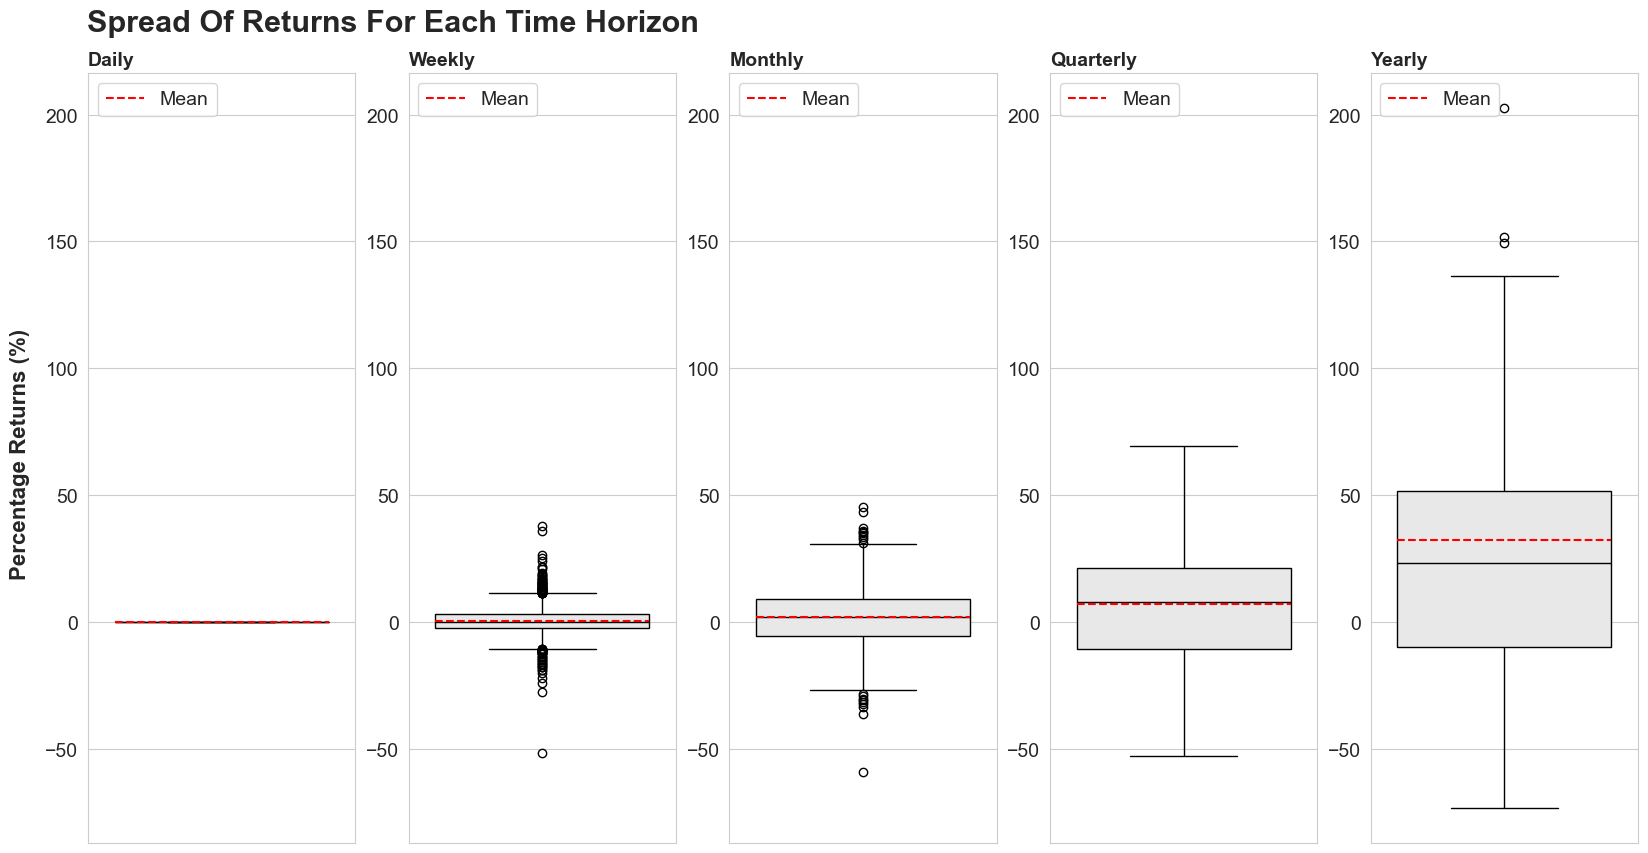

In [32]:
f, ax = plt.subplots(ncols=5, figsize=(20, 10), sharey=True)

for i, (k, v) in enumerate(returns_dict.items()):
    sns.boxplot(data=v, ax=ax[i], meanline=True, showmeans=True, meanprops={'color': 'red', 'lw': 1.5, 'label': 'Mean'}, color='#e8e8e8', linecolor='black')
    ax[i].set_title(k.capitalize(), fontweight='bold', fontsize=14, loc='left')
    ax[i].legend(fontsize=14, loc=2)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
    
dx, dy = 0.2777, 0.944
ydx, ydy = 0.086, 0.5
f.supylabel(t='Percentage Returns (%)', fontsize=16, fontweight='bold', x=ydx, y=ydy)
f.suptitle(t='Spread Of Returns For Each Time Horizon', fontsize=22, x=dx, y=dy, fontweight='bold')
plt.show()
f.savefig('../outputs/figures/spread_of_returns_time_period.png', dpi=300)


<font size=5 color=orange>Q </font>-- What does the overall correlation look like?

<Axes: >

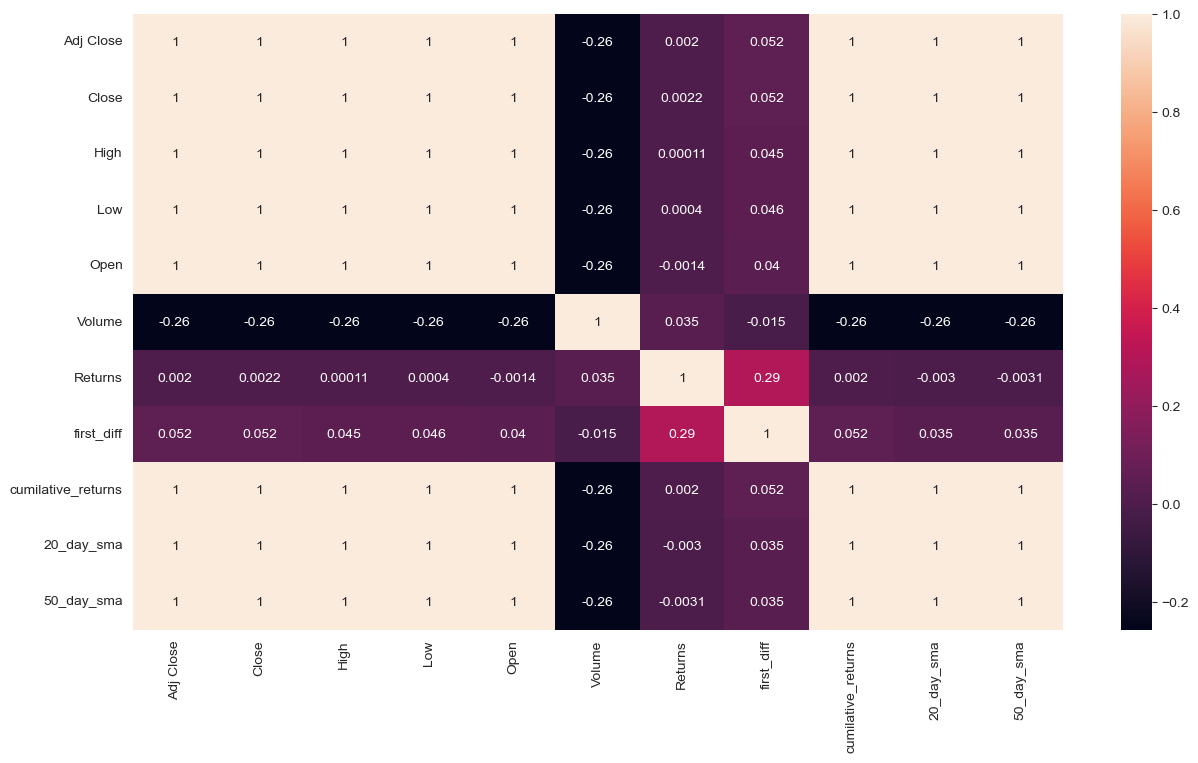

In [33]:
f, ax = plt.subplots()

sns.heatmap(df.corr(numeric_only=True), annot=True)

Columns are heavily correlated as most of the columns are dependent on each other.

---

### Augmented Dickey Fuller Test

---

In order to use an ARIMA model our data should be stationaly therefore having an normal distribution around the mean and should have no significant changes in the volatility or fluctuations of the data over different time periods. <br>

Therefore we run the Adfuller test, which is a statistical test for stationarity. It works by testing the null hypothesis on a sample that the timeseries in not stationary. Returning test statistics and p-value and Critical values.

In [34]:
from statsmodels.tsa.stattools import adfuller

In [35]:
# First Difference adj close results in really small p_value 3.5*10-30
results = adfuller(df['Adj Close'], autolag='AIC')
results

(4.0047221799368415,
 1.0,
 39,
 10985,
 {'1%': -3.4309454327484765,
  '5%': -2.8618031484539372,
  '10%': -2.5669100687949324},
 29128.159706328435)

In [36]:
# First Difference adj close results in really small p_value 3.5*10-30
results = adfuller(df['Returns'], autolag='AIC')
results

(-30.004927912486266,
 0.0,
 11,
 11013,
 {'1%': -3.4309439185375097,
  '5%': -2.8618024793230608,
  '10%': -2.566909712618015},
 -47616.67158176676)

In [37]:
# pct change adj close results in p-value of 0
results = adfuller(df['first_diff'], autolag='AIC')
results

(-17.697628923167034,
 3.548793088467637e-30,
 39,
 10985,
 {'1%': -3.4309454327484765,
  '5%': -2.8618031484539372,
  '10%': -2.5669100687949324},
 29132.061437787357)

The first item in both tuples are the test statistics which is then used to generate the second value in the tuple the p value <font color=red> If the p value > 0.05 we reject the null hypothesis that the graph is stationary</font> and apply another transform.<br>

Finally the last 3 values contain the test statistic for the critical values, our test statistic ended up bieng a lot lower than these so we can reject the null hypothesis

---

### Plotting ACF and PACF

---

Plotting the ACF and PACF is a good way to identify the correct model order. The Autocorrelation function is the correlation between the time series and an ofset n. So written like this, $\text{corr}(y_t, y_{t-n})$. <br>

The PACF or partial autocorrelation is the correlation between a time series and the lagged version of itself after we take away the effort of the correlation at smaller lags. Which means it is just the correlation associated with that particular lag.

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### Plot ACF and PACF graphs

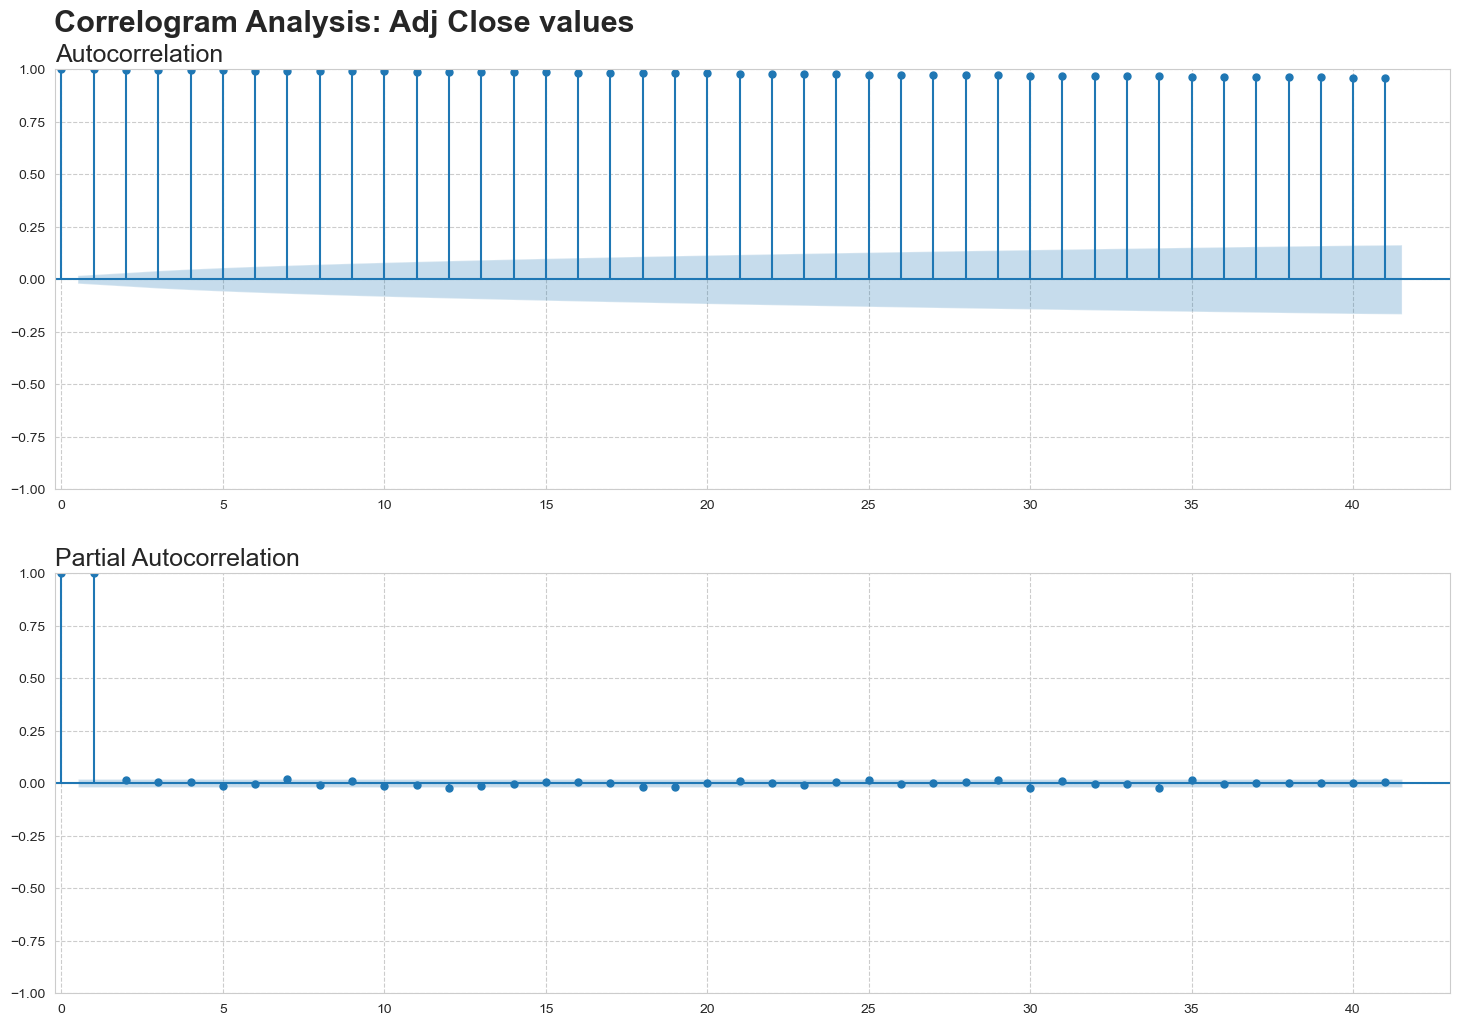

In [39]:
f, ax = plt.subplots(2, 1, figsize=(18, 12))

plot_acf(df['Adj Close'], ax=ax[0], title='')
plot_pacf(df['Adj Close'], ax=ax[1], title='')

dx, dy = 0.2855, 0.93
f.suptitle(t='Correlogram Analysis: Adj Close values', fontsize=22, fontweight='bold', x=dx, y=dy)

ax[0].set_title('Autocorrelation', fontdict={'size': 18, 'weight': 'light'}, loc='left')
ax[1].set_title('Partial Autocorrelation', fontdict={'size': 18, 'weight': 'light'}, loc='left')
for axes in ax:
    axes.set_xlim(-0.2, 43)#
    axes.grid(linestyle='--')
plt.show()

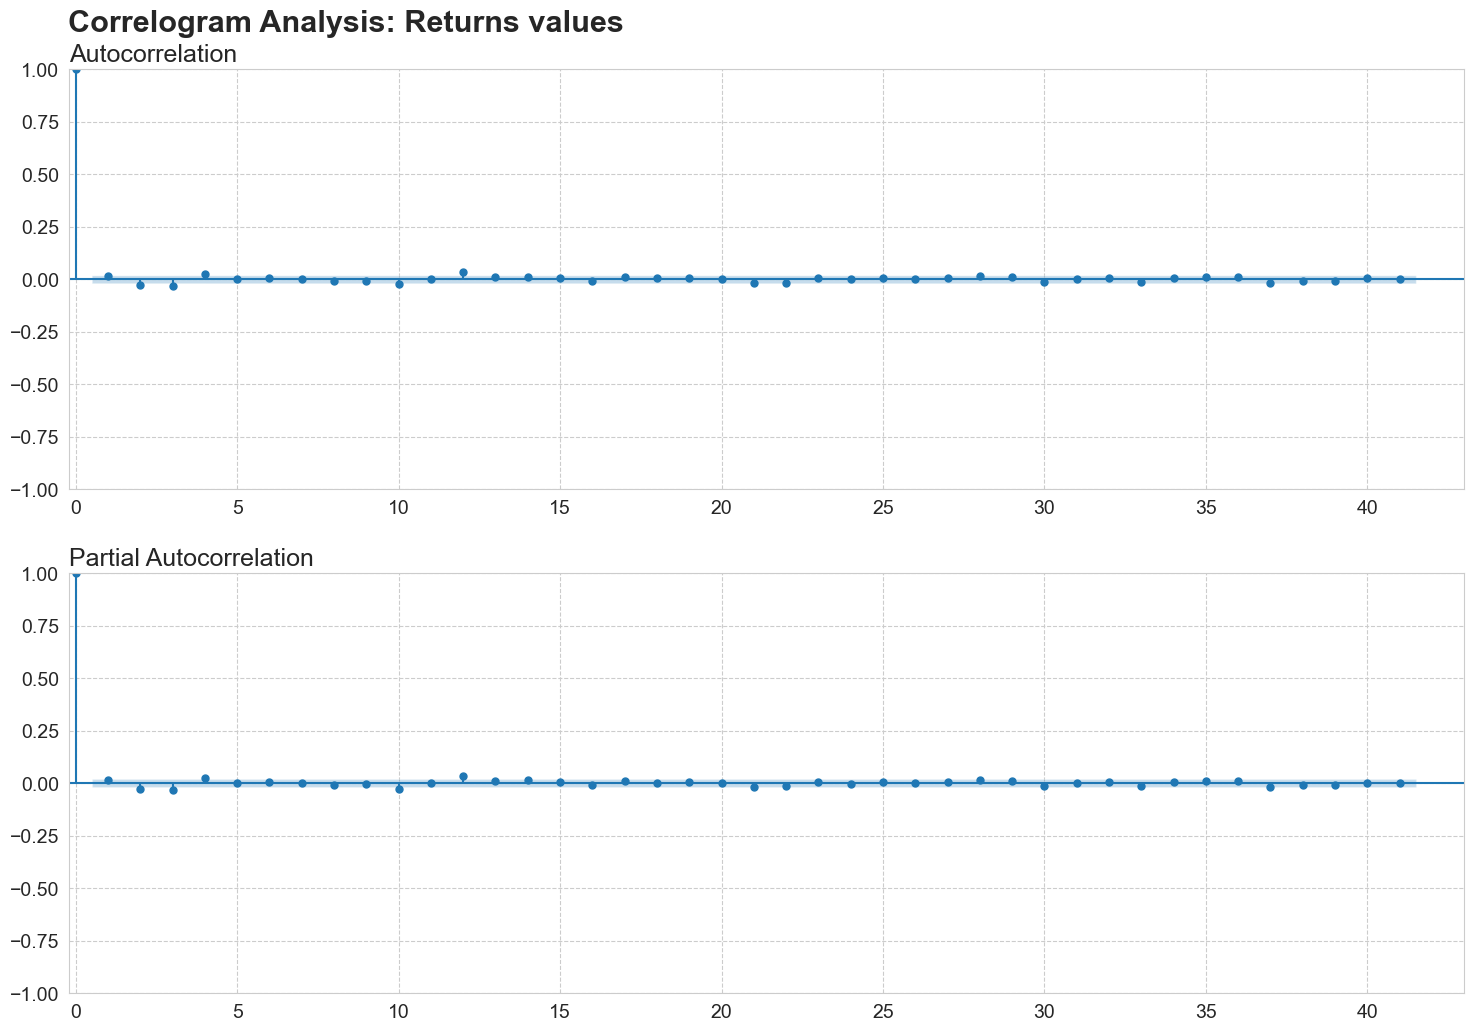

In [40]:
f, ax = plt.subplots(2, 1, figsize=(18, 12))

plot_acf(df['Returns'], ax=ax[0], title='')
plot_pacf(df['Returns'], ax=ax[1], title='')

dx, dy = 0.2785, 0.93
f.suptitle(t='Correlogram Analysis: Returns values', fontsize=22, fontweight='bold', x=dx, y=dy)

ax[0].set_title('Autocorrelation', fontdict={'size': 18, 'weight': 'light'}, loc='left')
ax[1].set_title('Partial Autocorrelation', fontdict={'size': 18, 'weight': 'light'}, loc='left')
for axes in ax:
    axes.set_xlim(-0.2, 43)#
    axes.grid(linestyle='--')
    axes.tick_params(axis='both', which='major', labelsize=14)
plt.show()

---

### ARIMA Modelling

---

The ARIMA model works by combining the AR and the MA models together. With I or intergrated part bieng the level of differencing done on the data. <br>

An $\text{AR}(p)$ model works by regressing the values of the time series against previous $\text(p)$ values of the same timeseries. So an $\text{AR}(p)$ model works like this below: <br>

$y_t = a_1y_{t-1} + a_2y_{t-2} + ... + a_py_{t-p} + \epsilon_t$ <br>

In a $\text{MA}(q)$ model we regress the values if the timeseries against the previous shock term values of the series. So an $\text{MA}(q)$ model works like this before.

$y_t = m_1\epsilon_{t-1} + m_2\epsilon_{t-2} + ... + m_q\epsilon_{t-q} + \epsilon_t$ <br>

And an $\text{ARMA}(p, q)$ model is just these two models added together so: <br>

$y_t = a_py_{t-p}+ m_q\epsilon_{t-q} + \epsilon_t$

In [41]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#### Train test split

In [42]:
num_rows = df.shape[0]
training_rows = int(np.floor(num_rows * 0.998))
training_data = df[:training_rows].set_index('Date')
testing_data = df[training_rows:].set_index('Date')

In [43]:
testing_data.shape[0]

23

#### Generate Models

In [44]:
p, d, q = 4, 0, 4

model = ARIMA(training_data['Returns'], order=(p,d,q))
results = model.fit()
print(results.summary())

d:\Miniconda\envs\data-dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Miniconda\envs\data-dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Miniconda\envs\data-dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                11002
Model:                 ARIMA(4, 0, 4)   Log Likelihood               23829.176
Date:                Fri, 06 Dec 2024   AIC                         -47638.353
Time:                        10:59:15   BIC                         -47565.294
Sample:                             0   HQIC                        -47613.740
                              - 11002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      4.185      0.000       0.001       0.002
ar.L1          0.0108      0.216      0.050      0.960      -0.413       0.435
ar.L2         -0.0469      0.160     -0.293      0.7

In [45]:
# In sample prediction test
date_difference = date(2024, 8, 1) - date(2024, 7, 1) 

In [46]:
# Get forecasted values and confidence intervals
vals = results.get_forecast(testing_data.shape[0])
vals_conf_interval = vals.conf_int()

d:\Miniconda\envs\data-dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [47]:
# Make a dataframe of forecasted mean and confidence intervals
forecast_df = pd.merge(left=vals.predicted_mean, right=vals_conf_interval, left_index=True, right_index=True)

In [48]:
# Get in sampled predictions based on the data both mean and confidence intervals
prediction = results.get_prediction(start=-date_difference.days)
prediction_mean = prediction.predicted_mean
prediction_conf_intervals = prediction.conf_int()

In [49]:
# Make a dataframe of prediction mean and confidence intervals
prediction_df = pd.merge(left=prediction_mean, right=prediction_conf_intervals, left_index=True, right_index=True)

In [50]:
def get_adj_close_from_predicted_returns(data: pd.Series, out_sample_forecast: bool = True) -> np.ndarray:
    """
        This function takes in the series of percentage returns, tranforms returns into Adjusted Close values in $

        Parameters:
        data (Pandas Series): takes in series of % return model predictions.
        out_sample_forecast (bool): due to indexxing the function is varied dealing with in-sample or out-of sample predictions.

        Returns:
        numpy array: Closing price in dollars.
    """
    # Get start index of predictions and find the adjusted close at the previous index of the main dataframe
    indexer = data.index[0]
    if out_sample_forecast:
        initial_value = df.loc[indexer-1, 'Adj Close']
    else:
        initial_value = df.set_index('Date').loc[indexer-pd.tseries.offsets.BusinessDay(1), 'Adj Close']
        
    adj_close_mean = [initial_value]

    # Calculate returns iteratively by multiplying the last closing price by percentage returns
    for val in data:
        new_mean = adj_close_mean[-1] * (1 + val)
        adj_close_mean.append(new_mean)

    # Get the new prices and ignore first element which is the index closing price
    adj_close_mean_real = adj_close_mean[1:]
    return np.array(adj_close_mean_real)

In [51]:
# Convert mean forecasted returns and confidence intervals into dollars closing price 
forecasted_adj_close_mean_real = get_adj_close_from_predicted_returns(forecast_df['predicted_mean'], out_sample_forecast=True)
forecasted_lower_interval_real = get_adj_close_from_predicted_returns(forecast_df['lower Returns'], out_sample_forecast=True)
forecasted_upper_inteval_real = get_adj_close_from_predicted_returns(forecast_df['upper Returns'], out_sample_forecast=True)

In [52]:
# Convert mean in-sample-predictions returns and confidence intervals into dollars closing price 
predicted_adj_close_mean_real = get_adj_close_from_predicted_returns(prediction_df['predicted_mean'], out_sample_forecast=False)
predicted_lower_interval_real = get_adj_close_from_predicted_returns(prediction_df['lower Returns'], out_sample_forecast=False)
predicted_upper_inteval_real = get_adj_close_from_predicted_returns(prediction_df['upper Returns'], out_sample_forecast=False)

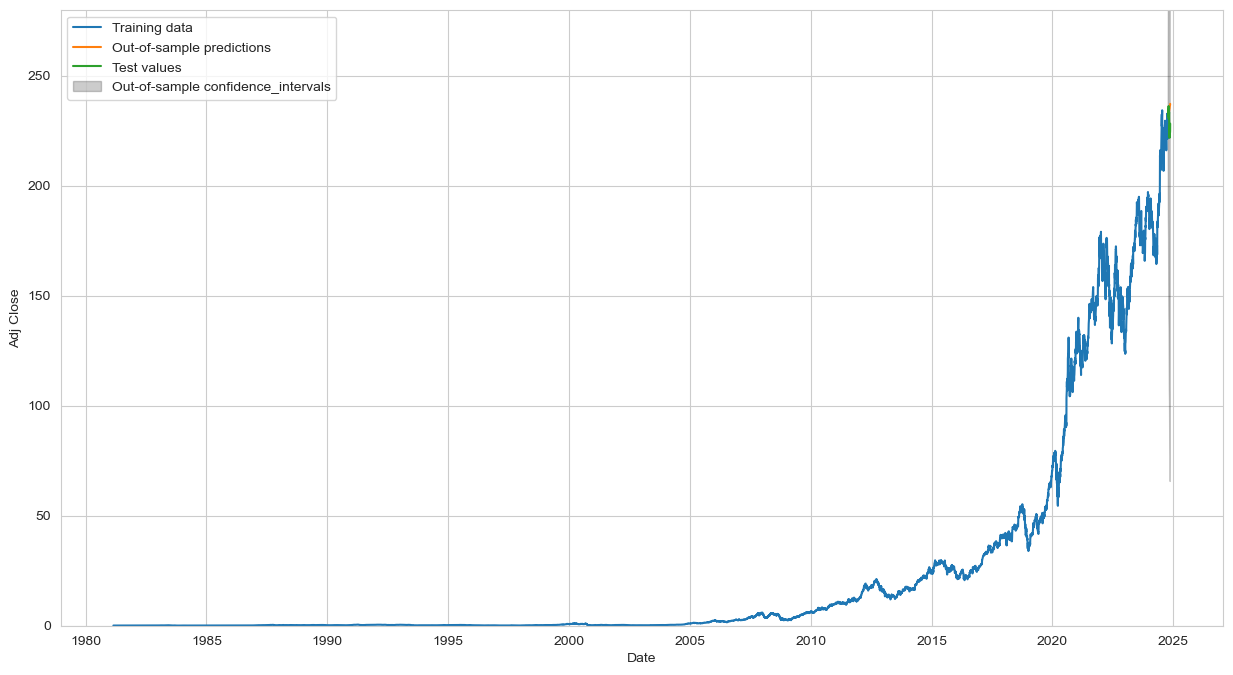

In [53]:
sns.lineplot(training_data['Adj Close'], label='Training data')
sns.lineplot(x=testing_data.index, y=forecasted_adj_close_mean_real, label='Out-of-sample predictions', alpha=1)
sns.lineplot(testing_data['Adj Close'], label='Test values', alpha=1)



plt.fill_between(x=testing_data.index, y1=forecasted_lower_interval_real, y2=forecasted_upper_inteval_real, label='Out-of-sample confidence_intervals', color='black', alpha=0.2)

plt.ylim(0, 280)
plt.legend(loc=2)
plt.show()

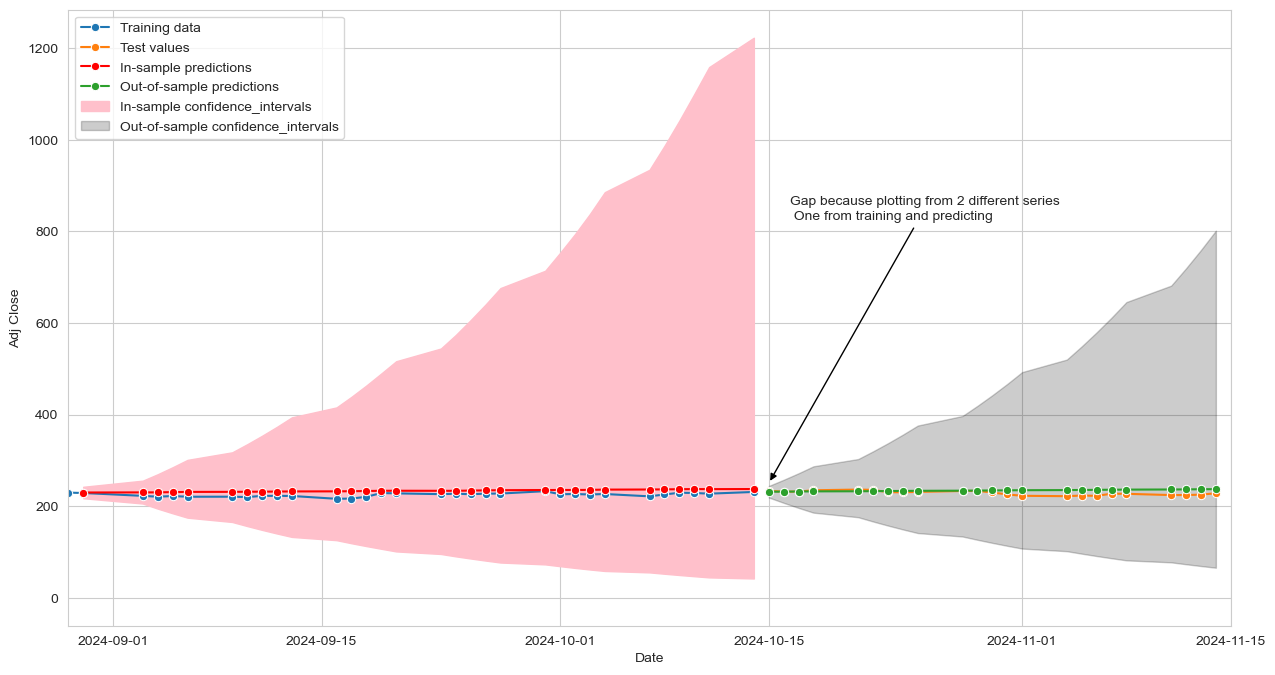

In [54]:
f, ax = plt.subplots()

sns.lineplot(training_data['Adj Close'], label='Training data', marker='o', ax=ax)
sns.lineplot(testing_data['Adj Close'], label='Test values', alpha=1, marker='o', ax=ax)

sns.lineplot(x=prediction_df.index, y=predicted_adj_close_mean_real, label='In-sample predictions', color='red', marker='o', ax=ax)
sns.lineplot(x=testing_data.index, y=forecasted_adj_close_mean_real, label='Out-of-sample predictions', alpha=1, marker='o', ax=ax)

ax.fill_between(x=prediction_df.index, y1=predicted_lower_interval_real, y2=predicted_upper_inteval_real, color='pink', label='In-sample confidence_intervals')
ax.fill_between(x=testing_data.index, y1=forecasted_lower_interval_real, y2=forecasted_upper_inteval_real, label='Out-of-sample confidence_intervals', color='black', alpha=0.2)

ax.set_xlim(prediction_df.index.min() - timedelta(days=1), testing_data.index.max() + timedelta(days=1))


ax.annotate('Gap because plotting from 2 different series\n One from training and predicting ', (date(2024, 10, 15), 250), xytext=(15, 190), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>', color='black'))
ax.legend(loc=2)
plt.show()

#### Model Diagnostics

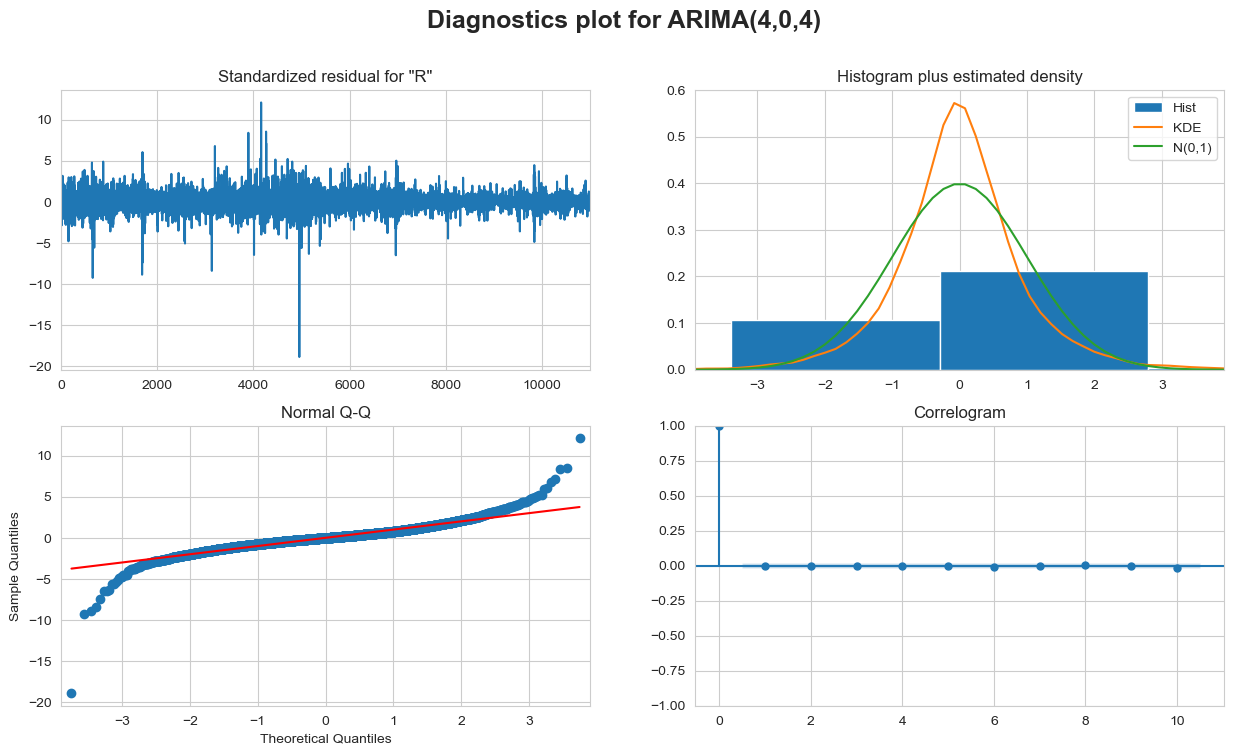

In [75]:
f = (results.plot_diagnostics())
dx, dy = 0.5, 0.98

f.suptitle(t=f'Diagnostics plot for ARIMA({p},{d},{q})', fontweight='bold', fontsize=18, x=dx, y=dy)

plt.show()
f.savefig('../outputs/figures/diagnostic_plot_arima.png', dpi=300)

Standardized Residual Plot <br>
The plot shows residuals fluctuating mostly between -5 and +5, with one notable outlier around observation 5000 reaching -20.<br> The pattern suggests relatively consistent volatility over time, though there are clusters of higher volatility periods.<br>

Histogram plus Estimated Density (Top Right)<br>
The histogram shows the distribution of residuals with an overlaid kernel density estimate (orange line) and normal distribution (green line).<br> The distribution appears slightly leptokurtic (more peaked than normal) and shows some right skewness. The residuals are concentrated around zero but have heavier tails than a normal distribution would predict.<br>

Normal Q-Q Plot (Bottom Left) <br>
This quantile-quantile plot compares the residuals against theoretical normal quantiles. The blue points <br> follow the red reference line reasonably well in the middle but deviate at the tails, particularly below -3 and above +3 standard deviations. The extreme outlier at -20 is clearly visible at the bottom left.<br>

Correlogram (Bottom Right)<br>
The autocorrelation function plot shows very low correlation values across all lags except for lag 0 (which is always 1.0). All other lags show correlations very close to zero, indicating that the residuals are effectively uncorrelated with their past values, which is a desirable property for a well-fitted model.

#### Metrics

In [56]:
mse = mean_squared_error(testing_data['Adj Close'].values, forecasted_adj_close_mean_real)
rmse = mean_squared_error(testing_data['Adj Close'].values, forecasted_adj_close_mean_real, squared=False)
mape = mean_absolute_percentage_error(testing_data['Adj Close'].values, forecasted_adj_close_mean_real)
print(f"The RMSE: {round(rmse, 2)}, and the MSE: {round(mse, 2)}, and MAPE: {round(mape, 2)}")

The RMSE: 8.03, and the MSE: 64.48, and MAPE: 0.03


In [57]:
print(f"The AIC: {round(results.aic, 2)}, The BIC: {round(results.bic,2)}")

The AIC: -47638.35, The BIC: -47565.29


#### Optimising model

In [58]:
# """
# Iterate over every combination of P and Q value for arima model,
# make a dataset of key model metrics, including aic, bic, mse, maep
# """
# order_ai_bic = []
# num_args_p, num_args_q = (0, 5), (0, 5)
# for p in range(num_args_p[0], num_args_p[1]):
#     for q in range(num_args_q[0], num_args_q[1]):
#         try:
#             model = ARIMA(training_data['Returns'], order=(p, 0, q))
#             results = model.fit()
#             predictions_inp_optimal_model = results.forecast(testing_data['Returns'].shape[0])
#             true_vals = testing_data['Returns'].values
#             mse_optimal = mean_squared_error(true_vals, predictions_inp_optimal_model)
#             maep_optimal = mean_absolute_percentage_error(true_vals, predictions_inp_optimal_model)
#             order_ai_bic.append((p, q, results.aic, results.bic, mse_optimal, maep_optimal))
#         except:
#             print(p, q, None, None, None, None)

# order_df = pd.DataFrame(order_ai_bic, columns=["p", "q", "aic", "bic", "mse", "maep"])
# order_df.to_csv(
#     str(PROCESSED_DATA_PATH / f"arima_order_aic_bic.csv"),
#     index=0,
# )

In [59]:
best_model = pd.read_csv('../data/02_processed/arima_order_aic_bic.csv')
best_model.sort_values(by=['mse', 'aic'], ascending=[True, False])[8:10]

,p,q,aic,bic,mse,maep
23,4,3,-47633.052643,-47567.300152,0.000113,2.172311e+11
24,4,4,-47638.352809,-47565.294486,0.000113,2.160777e+11


Keep in mind the mse and maep are different as these are relative to daily returns and not Adjusted Close <br>
We already have one the better models so we countinue to use this one as there is no point in using the other models